# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/)
* [CycleGAN](https://github.com/junyanz/CycleGAN)
* [A whole list](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.

![GAN diagram](assets/gan_diagram.png)

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector the generator uses to contruct it's fake images. As the generator learns through training, it figures out how to map these random vectors to recognizable images that can fool the discriminator.

The output of the discriminator is a sigmoid function, where 0 indicates a fake image and 1 indicates an real image. If you're interested only in generating new images, you can throw out the discriminator after training. Now, let's see how we build this thing in TensorFlow.

In [3]:
pip install tensorflow qrcode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.6 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import os
import numpy as np
import qrcode
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm


In [5]:
# Directory to save the QR codes
qr_code_dir = "qr_code_images"
os.makedirs(qr_code_dir, exist_ok=True)

# Generate 10,000 QR code images
num_images = 10000
image_size = 28

def generate_qr_code(data, file_path, size=image_size):
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(data)
    qr.make(fit=True)
    img = qr.make_image(fill='black', back_color='white').resize((size, size))
    img.save(file_path)

print("Generating QR codes...")
for i in tqdm(range(num_images)):
    data = f"Sample data {i}"
    file_path = os.path.join(qr_code_dir, f"qr_code_{i}.png")
    generate_qr_code(data, file_path)


Generating QR codes...


100%|██████████| 10000/10000 [01:16<00:00, 130.78it/s]


In [6]:
def load_qr_code_images(directory, image_size):
    images = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        img = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=(image_size, image_size))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img.astype('float32') / 255.0
        img = img.flatten()
        images.append(img)
    return np.array(images)

qr_code_images = load_qr_code_images(qr_code_dir, image_size)


In [7]:
# Define the Generator
def build_generator(z_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, input_shape=(z_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(image_size * image_size, activation='tanh')
    ])
    return model

# Define the Discriminator
def build_discriminator(input_shape):
    model = tf.keras.Sequential([
        layers.Dense(512, input_shape=input_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Hyperparameters
z_dim = 100
input_shape = (image_size * image_size,)

# Build and compile the models
generator = build_generator(z_dim)
discriminator = build_discriminator(input_shape)

discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input = tf.keras.Input(shape=(z_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')


In [8]:
# Function to plot generated images
def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, [examples, z_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, image_size, image_size)

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.show()


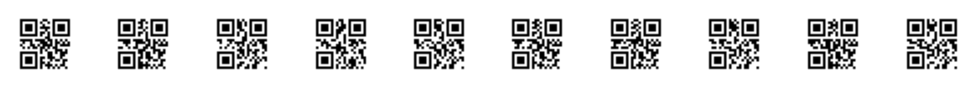

In [9]:
def plot_qr_codes(images, num_images=10, dim=(1, 10), figsize=(10, 1)):
    plt.figure(figsize=figsize)
    for i in range(num_images):
        plt.subplot(dim[0], dim[1], i + 1)
        img = images[i].reshape(image_size, image_size)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot some QR codes from the dataset
plot_qr_codes(qr_code_images, num_images=10)

2/2 [==============================] - 0s 9ms/step
Epoch 0 | Discriminator Loss: 0.623943954706192 | Generator Loss: 0.553483247756958
1/1 [==============================] - 0s 128ms/step


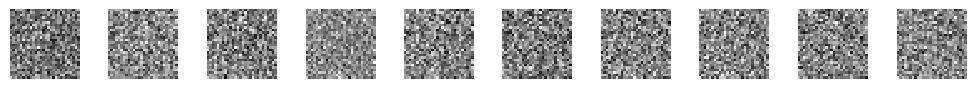

2/2 [==============================] - 0s 11ms/step
Epoch 200 | Discriminator Loss: 0.8537968099117279 | Generator Loss: 0.5948563814163208
1/1 [==============================] - 0s 24ms/step


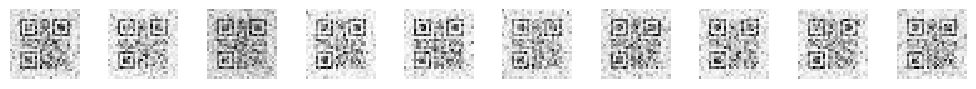

2/2 [==============================] - 0s 9ms/step
Epoch 400 | Discriminator Loss: 0.6085178256034851 | Generator Loss: 1.2786190509796143
1/1 [==============================] - 0s 23ms/step


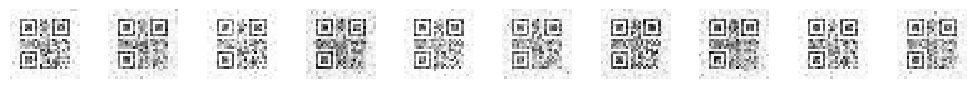

2/2 [==============================] - 0s 8ms/step
Epoch 600 | Discriminator Loss: 0.6265172064304352 | Generator Loss: 1.138207197189331
1/1 [==============================] - 0s 24ms/step


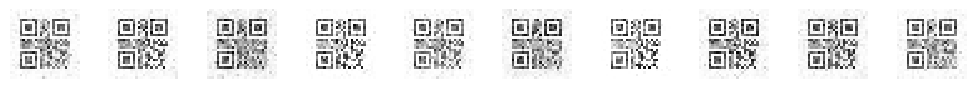

2/2 [==============================] - 0s 7ms/step
Epoch 800 | Discriminator Loss: 0.6498341858386993 | Generator Loss: 1.0620672702789307
1/1 [==============================] - 0s 21ms/step


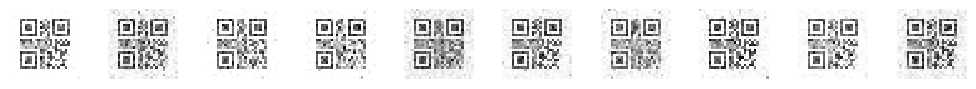

2/2 [==============================] - 0s 9ms/step
Epoch 1000 | Discriminator Loss: 0.6547797918319702 | Generator Loss: 1.0265520811080933
1/1 [==============================] - 0s 22ms/step


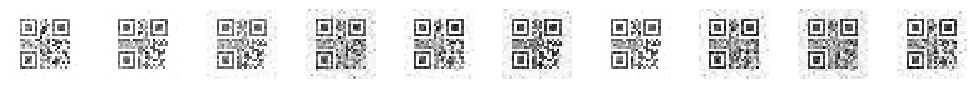

2/2 [==============================] - 0s 9ms/step
Epoch 1200 | Discriminator Loss: 0.6748231947422028 | Generator Loss: 0.9549727439880371
1/1 [==============================] - 0s 23ms/step


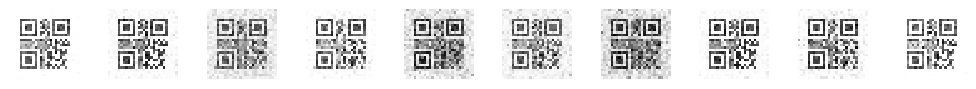

2/2 [==============================] - 0s 9ms/step
Epoch 1400 | Discriminator Loss: 0.6270727813243866 | Generator Loss: 0.9433166980743408
1/1 [==============================] - 0s 29ms/step


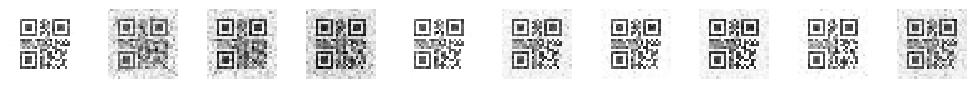

2/2 [==============================] - 0s 7ms/step
Epoch 1600 | Discriminator Loss: 0.6743254065513611 | Generator Loss: 0.8852962255477905
1/1 [==============================] - 0s 28ms/step


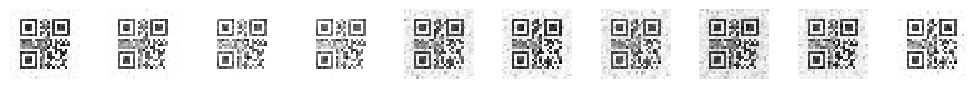

2/2 [==============================] - 0s 11ms/step
Epoch 1800 | Discriminator Loss: 0.6472294926643372 | Generator Loss: 0.935516357421875
1/1 [==============================] - 0s 29ms/step


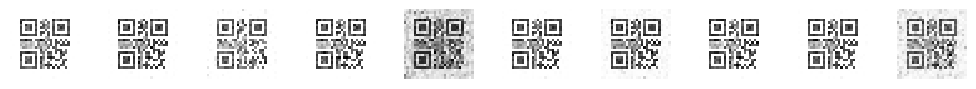

2/2 [==============================] - 0s 12ms/step


In [10]:
# Training loop
batch_size = 64
epochs = 2000  # Increased epochs for better training

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, qr_code_images.shape[0], batch_size)
    real_images = qr_code_images[idx]
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    fake_images = generator.predict(noise)

    real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing
    fake_labels = np.zeros((batch_size, 1)) + 0.1  # Label smoothing

    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 200 == 0:  # Plot every 200 epochs for better monitoring
        print(f"Epoch {epoch} | Discriminator Loss: {d_loss[0]} | Generator Loss: {g_loss}")
        plot_generated_images(epoch, generator)


In [11]:
# Final evaluation
# Evaluate discriminator on real images
real_labels = np.ones((qr_code_images.shape[0], 1))
d_loss_real, d_accuracy_real = discriminator.evaluate(qr_code_images, real_labels, verbose=0)

# Evaluate discriminator on fake images
noise = np.random.normal(0, 1, (qr_code_images.shape[0], z_dim))
fake_images = generator.predict(noise)
fake_labels = np.zeros((qr_code_images.shape[0], 1))
d_loss_fake, d_accuracy_fake = discriminator.evaluate(fake_images, fake_labels, verbose=0)

print(f"Final Discriminator Accuracy on Real Images: {d_accuracy_real * 100:.2f}%")
print(f"Final Discriminator Accuracy on Fake Images: {d_accuracy_fake * 100:.2f}%")


313/313 [==============================] - 1s 3ms/step
Final Discriminator Accuracy on Real Images: 88.99%
Final Discriminator Accuracy on Fake Images: 43.88%
